### System

$
H = H_0 + H_{SB} = H_S + H_{B} + H_{SB}
$

$
H_S = H_{dimer} + H_{I}(t)
$

$
H_{dimer} = 0* |0\rangle\langle0| + \omega_a |A\rangle\langle A| + \omega_b |B\rangle\langle B| + J (|B\rangle\langle A| + |A\rangle\langle B|) + (\omega_a + \omega_b) |AB\rangle\langle AB|
$

$
H_{B} = \sum_k \hbar \omega_k b_k^{\dagger} b_k
$

$
H_{I}(t) = \hbar  g ( \Sigma_+ + \Sigma_-) \cdot (f(t) + f(t)^{*})
\quad \text{,} \quad E(t) \equiv f(t) \cdot E_0 \propto \exp^{i \omega_a t + \phi} \cdot \delta(t) \quad \text{,} \quad g =  \mu * E_0
$

### Decay operators
$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$

In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import scipy.constants as const
from qutip import *
import numpy as np
import itertools
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = os.getcwd()  # Gets the current working directory
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook #%matplotlib inline


# Phase Cycling for Averaging
phases = [-i * np.pi / 2 for i in range(4)] # GIVES WEIRD RESULTS
hbar        = 1#* const.hbar
Boltzmann   = 1#* const.Boltzmann
c           = 1# * const.c

# Print the values of hbar and Boltzmann constant
print("Reduced Planck's constant (hbar):", hbar, "J·s")
print("Boltzmann constant (k_B):", Boltzmann, "J/K")
print("Speed of light (c):", c, "m/s")

wc      = np.inf
mu_a    = wc
mu_b    = mu_a
omega_a = mu_b
omega_b = omega_a
fine_spacing = omega_b
times   = [0]
fac_twopi = 1#* 2*np.pi
#Delta  = 200    # inhomogeneous distribution width of the monomer transitions (cm⁻¹, actually also s⁻1, when c = 1)

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Reduced Planck's constant (hbar): 1 J·s
Boltzmann constant (k_B): 1 J/K
Speed of light (c): 1 m/s



System Parameters:
------------------
N_atoms: 1
mu_a: 1
E0: 0.15089999999999998
omega_a: 0.47973
omega_b: 0.47973
omega_L: 0.47973
g_value: 0.15089999999999998
rabi_0: 0.15089999999999998
delta: 0.0
rabi_gen: 0.15089999999999998
t_max: 600
fine_spacing: 2
gamma_0: 0.0005305164769729845
gamma_phi: 0.0015915494309189533

Operators:
----------
Dip_op: Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]
Deph_op: Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-1.  0.]
 [ 0.  1.]]

E_amps: [0.15089999999999998, 0.15089999999999998, 0.001509]
Delta_ts: [7.5, 7.5, 7.5]



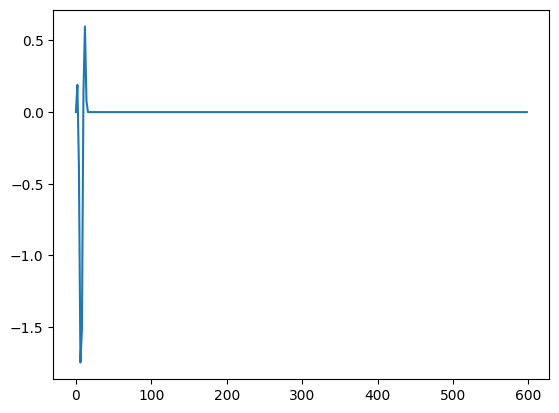

 [*****    22%           ] Elapsed 0.20s / Remaining 00:00:00:00

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


 Total run time:   0.82s*] Elapsed 0.82s / Remaining 00:00:00:00
 Total run time:   1.45s*] Elapsed 1.44s / Remaining 00:00:00:00


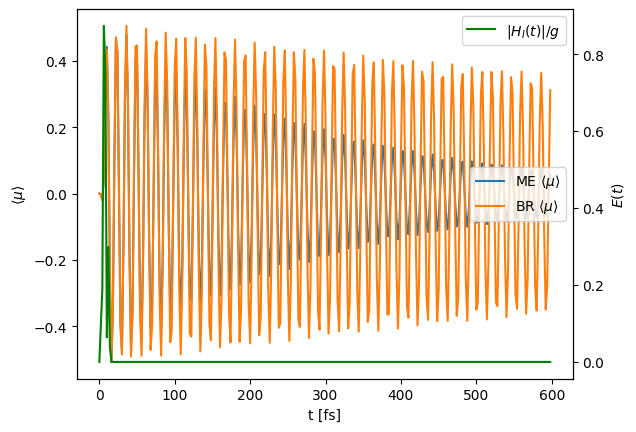

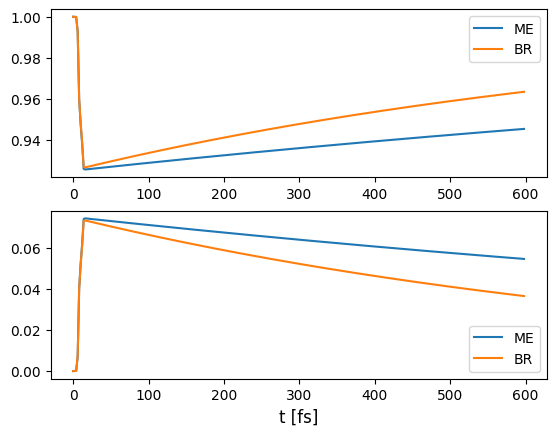

In [2]:
# =============================
# SYSTEM PARAMETERS
# =============================
N_atoms = 1
Coupled = False
omega_L = 0.47973       # reciprocal fs            #fac_twopi*c*16000        # for N_atoms=2  excitation in the center of one-exciton manifold
E_freqs = [omega_L] * 3 # Laser frequencies

# Define Atomic States
atom_g, atom_e = basis(2, 0), basis(2, 1)      # Ground, Excited states

# =============================
# MORE FUNCTIONS
# =============================
def plot_positive_color_map(x, y, data, T = np.inf, space="real", type="real", positive=False, safe=False):
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        x (np.array): 1D array of x values.
        y (np.array): 1D array of y values.
        data (np.array): 2D array of data values aligned with x and y.
        T (float): Temperature parameter to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use only positive values of x and y.
        safe (bool): If True, saves the plot to a file.

    Returns:
        None
    """
    # Convert x and y into 1D arrays if they're not
    x = np.array(x)
    y = np.array(y)

    if positive:
        # Filter for positive x and y values
        positive_x_indices = np.where(x > 0)[0]  # Indices where x > 0
        positive_y_indices = np.where(y > 0)[0]  # Indices where y > 0
        x = x[positive_x_indices]
        y = y[positive_y_indices]
        data = data[np.ix_(positive_y_indices, positive_x_indices)]

    label = r"$\propto E_{out} / E_0$"# \quad \propto \quad P / E_0
    if space == "real":
        colormap = "viridis"
        title = f"Real space 2D Spectrum"
        if T != np.inf:
            title += f" at T ={T:.2f}"
        x_title = r"$t_{det}$ [fs]"
        y_title = r"$\tau_{coh}$ [fs]"
    elif space == "freq":
        x = x * 10/3
        y = y * 10/3
        colormap = "plasma"
        if type == "real":
            title = f"Freq space, Real 2D Spectrum"
            data = np.real(data)
        elif type == "imag":
            title = f"Freq space, Imag 2D Spectrum"
            data = np.imag(data)
        elif type == "abs":
            title = f"Freq space, Abs 2D Spectrum"
            data = np.abs(data)
        elif type == "phase":
            title = "Freq space, Phase 2D Spectrum"
            data = np.angle(data)
        else:
            raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")

        if T != np.inf:
            title += f" at T ={T:.2f}"

        x_title = r"$\omega_{t_{det}}$ [10⁴ cm⁻¹]"
        y_title = r"$\omega_{\tau_{coh}}$ [10⁴ cm⁻¹]"

    else:
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")

    # Check and adjust the dimensions of x, y, and data
    if data.shape[1] != len(x):
        raise ValueError(f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]}).")
    if data.shape[0] != len(y):
        raise ValueError(f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]}).")

    # Add 1 to the dimensions of x and y for correct pcolormesh behavior
    x = np.concatenate([x, [x[-1] + (x[-1] - x[-2])]])  # Add an extra value for the last x edge
    y = np.concatenate([y, [y[-1] + (y[-1] - y[-2])]])  # Add an extra value for the last y edge

    # Plot the color map
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(x, y, data / mu_a, shading="auto", cmap=colormap)
    plt.colorbar(label=label)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True
    if safe and output_dir is not None:
        filename_parts = [
            f"N={N_atoms}",
            f"mua={mu_a:.0f}",
            f"E0={E0:.2e}",  # Use scientific notation for E0
            f"wa={omega_a:.2f}",
            f"wL={omega_L/omega_a:.1f}wa",
            f"g={g_value:.2e}", #use scientific notation
            f"rabi0={rabi_0:.2f}",
            f"delta={delta:.2f}",
            f"rabigen={rabi_gen:.2f}",
            f"g0={gamma_0:.3f}",
            f"gphi={gamma_phi:.3f}",
            f"pos={positive}",
            f"space={space}"
        ]

        if N_atoms == 2:
            filename_parts.insert(1, f"J_{J:.1f}")  # Insert J after N_atoms if it exists

        if space == "freq":
            filename_parts.append(f"type_{type}")

        file_name_combined = "_".join(filename_parts) + ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)


    plt.show()
def Plot_example_evo(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k):
    args0 = get_args(times_0[0], 0, phi_1)
    args1 = get_args(times_0[i], 1, phi_2)
    args2 = get_args(times_1[j-i], 2, 0)

    times1 = times_0[:i]
    times2 = times_1[:j]
    times3 = times_2

    # Calculate the electric fields for each time range
    E_1 = [E_amps[0] * (El_field(t, args0)) for t in times1]
    E_2 = [E_amps[1] * (El_field(t, args1)) for t in times2]
    E_3 = [E_amps[2] * (El_field(t, args2)) for t in times3]
    times_plot = np.concatenate([times1, times2, times3])
    E_total = E_1 + E_2 + E_3

    fig, axs = plt.subplots(len(e_op_list)+1, 1, figsize=(15, 10), sharex=True)

    axs[0].plot(times_plot, E_total, label='Electric Field (Real part)', color='black')
    axs[0].set_ylabel('E')

    # Add vertical lines to mark pulse times
    axs[0].axvline(times_0[0] + Delta_ts[0], color='r', linestyle='--', label='Pulse 1')
    axs[0].axvline(times_0[i] + Delta_ts[1], color='g', linestyle='--', label='Pulse 2')
    axs[0].axvline(times_1[j-i] + Delta_ts[2], color='g', linestyle='--', label='Pulse 3')
    axs[0].axvline(times_2[k], color='b', linestyle='--', label='Detection')
    axs[0].legend()

    # Initialize an empty list to store all the data for plotting
    datas = []

    # Append the data for each quantum state based on the times
    for idx in range(len(e_op_list)):
        datas.append(np.concatenate([data_1.expect[idx][:i], data_2.expect[idx][:j], data_f.expect[idx]]))  # data for first state

    # Loop over the datas and plot each expectation value
    for idx, (data, label) in enumerate(zip(datas, e_op_labels)):
        axs[idx+1].plot(times_plot, data)
        axs[idx+1].set_ylabel(label)
        axs[idx+1].legend()

    fig.suptitle(f"tau = {tau:.2f}, T = {T_val:.2f}")
    axs[-1].set_xlabel('t [fs]')
    plt.show()
def Plot_example_evo_with_DipOp(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k):
    args0 = get_args(times_0[0], 0, phi_1)
    args1 = get_args(times_0[i], 1, phi_2)
    args2 = get_args(times_1[j-i], 2, 0)

    times1 = times_0[:i]
    times2 = times_1[:j]
    times3 = times_2

    # Calculate the electric fields for each time range
    E_1 = [E_amps[0] * (El_field(t, args0)) for t in times1]
    E_2 = [E_amps[1] * (El_field(t, args1)) for t in times2]
    E_3 = [E_amps[2] * (El_field(t, args2)) for t in times3]
    times_plot = np.concatenate([times1, times2, times3])
    E_total = E_1 + E_2 + E_3

    fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

    # Plot the electric field
    axs[0].plot(times_plot, E_total, label='Electric Field (Real part)', color='black')
    axs[0].set_ylabel('E')

    # Add vertical lines to mark pulse times
    axs[0].axvline(times_0[0] + Delta_ts[0], color='r', linestyle='--', label='Pulse 1')
    axs[0].axvline(times_0[i] + Delta_ts[1], color='g', linestyle='--', label='Pulse 2')
    axs[0].axvline(times_1[j-i] + Delta_ts[2], color='g', linestyle='--', label='Pulse 3')
    axs[0].axvline(times_2[k], color='b', linestyle='--', label='Detection')
    axs[0].legend()

    # Initialize an empty list to store all the expectation values of Dip_op
    datas = []
    expect_1 = [expect(Dip_op, state) for state in data_1.states]
    expect_2 = [expect(Dip_op, state) for state in data_2.states]
    expect_f = [expect(Dip_op, state) for state in data_f.states]
    # Append the expectation value of Dip_op for each state at the corresponding times
    for data in [data_1, data_2, data_f]:
        # Calculate expect(Dip_op, psi) at the appropriate indices
        datas.append(np.concatenate([expect_1[:i], expect_2[:j], expect_f]))

    # Plot the expectation values for each state
    for data in datas:
        axs[1].plot(times_plot, data)

    axs[1].set_ylabel('Expectation of Dip_op')
    axs[1].legend()

    fig.suptitle(f"tau = {tau:.2f}, T = {T_val:.2f}")
    axs[-1].set_xlabel('t [fs]')
    plt.show()
def get_times_for_T(T, spacing=fine_spacing):
    # Adjust the first and last entries of times_tau
    first_tau = (Delta_ts[0] + Delta_ts[1])
    last_tau = np.floor((t_max - Delta_ts[2] - T - Delta_ts[0]) / spacing) * spacing
    times_tau = np.arange(first_tau, last_tau, spacing)
    # Adjust the first and last entries of times_t
    first_t = (Delta_ts[2])
    last_t = np.floor((t_max - Delta_ts[0] - T - 2 * Delta_ts[2]) / spacing) * spacing
    times_t = np.arange(first_t, last_t, spacing)

    return times_tau, times_t
def pulse_envelope(t, t0, Delta):
    E = np.cos(np.pi * (t - t0) / (2 * Delta))**2 * np.heaviside(t - (t0 - Delta), 0) * np.heaviside(t0 + Delta - t, 0)
    return 1*E
def El_field(t, args):
    """ Define a time-dependent electric field pulse. """
    t0, Delta, omega, phi, E0 = args['time'], args['Delta'], args['omega'], args['phi'], args['E_amp']
    E = 1*pulse_envelope(t, t0, Delta)
    return  E * np.exp(1j * (omega * t) + phi) # #    phase kick
def El_field_op(t, args):
    E = El_field(t, args)
    E_op = E + np.conj(E)
    return E_op
def get_args(t = times[0], i = 0, phi = 0):
    return {
        'phi': phi,
        'time': t + Delta_ts[i],
        'omega': E_freqs[i],
        'Delta': Delta_ts[i],
        'E_amp': E_amps[i]
    }

def process_phi_combination(phi_1, phi_2, times_T):
    # Function to handle parallel processing for each phi1, phi2 combination
    full_data_array = np.empty((len(times_T)), dtype=object)
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(compute_two_dimensional_polarization, times_T[i], phi_1, phi_2) for i in range(len(times_T))]
        for i, future in enumerate(as_completed(futures)):
            full_data_array[i] = future.result()
    return full_data_array
def parallel_process_all_combinations(phases, times_T):
    # Call the function to parallelize the whole process
    all_results = {}
    with ProcessPoolExecutor() as executor:
        futures = [(executor.submit(process_phi_combination, phi1, phi2, times_T), phi1, phi2) for phi1, phi2 in itertools.product(phases, phases)]
        for future, phi1, phi2 in futures:
            all_results[(phi1, phi2)] = future.result()
    return all_results
def average_and_plot_results(results, times_T):
    # the time data can even be padded
    num_combinations = len(results)
    num_time_steps = len(times_T) - 1
    averaged_data_array = np.empty(num_time_steps, dtype=object)
    for i in range(num_time_steps):
        sum_data = None
        ts, taus = None, None
        for _, full_data_array in results.items():
            ts, taus, data_time = full_data_array[i]
            if sum_data is None:
                sum_data = np.zeros_like(data_time)
            sum_data += data_time
        averaged_data = sum_data / num_combinations
        pad_val = 1
        padded_size = (int(np.round(averaged_data.shape[0] * pad_val)), int(np.round(averaged_data.shape[1] * pad_val)))
        padded_averaged_data = np.pad(averaged_data, ((0, padded_size[0] - averaged_data.shape[0]), (0, padded_size[1] - averaged_data.shape[1])), mode='constant', constant_values=0)
        padded_ts = np.linspace(ts[0], np.round(ts[-1] * pad_val), padded_size[1])
        padded_taus = np.linspace(taus[0], np.round(taus[-1] * pad_val), padded_size[0])
        averaged_data_array[i] = (padded_ts, padded_taus, padded_averaged_data)
    return averaged_data_array
def extend_and_transform_averaged_results(averaged_results):
    global_taus = averaged_results[0][1]
    global_ts = averaged_results[0][0]
    global_t_freqs = np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0]))
    global_tau_freqs = np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0]))
    global_data_time = np.zeros((len(global_taus), len(global_ts)))
    global_data_freq = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)

    def find_closest_index(local_times, global_times):
        return [np.argmin(np.abs(global_times - local_time)) for local_time in local_times]

    for i, (ts, taus, data_time) in enumerate(averaged_results):
        data_extended_time = np.zeros_like(global_data_time)
        tau_indices = find_closest_index(taus, global_taus)
        t_indices = find_closest_index(ts, global_ts)
        for local_tau_idx, global_tau_idx in enumerate(tau_indices):
            for local_t_idx, global_t_idx in enumerate(t_indices):
                data_extended_time[global_tau_idx, global_t_idx] = data_time[local_tau_idx, local_t_idx]
        data_extended_freq = np.fft.fft2(data_extended_time)
        global_data_time += data_extended_time
        global_data_freq += data_extended_freq
        plot_positive_color_map(ts, taus, data_time, times_T[i])
        plot_positive_color_map(global_t_freqs, global_tau_freqs, data_extended_freq, times_T[i], space="freq", positive=True, type="abs")

    global_data_time /= len(averaged_results)
    global_data_freq /= len(averaged_results)
    plot_positive_color_map(global_ts, global_taus, global_data_time, safe=False)
    plot_positive_color_map(global_t_freqs, global_tau_freqs, global_data_freq, space="freq", type="abs", positive=True, safe=False)
    return global_data_time, global_data_freq
def main(phases, times_T):
    all_results = parallel_process_all_combinations(phases, times_T)
    sorted_results = {k: sorted(v, key=lambda data_item: len(data_item[0]), reverse=True)[:-1] for k, v in all_results.items()}
    averaged_results = average_and_plot_results(sorted_results, times_T)
    return averaged_results

def H_int(t, args):
    E0 = args['E_amp']
    g = E0 * mu_a
    return g * Dip_op.unit() * El_field_op(t, args) / 2
def H_sys(args):
    return H0 + QobjEvo(H_int, args)

def main(phases, times_T):
    all_results = parallel_process_all_combinations(phases, times_T)
    sorted_results = {k: sorted(v, key=lambda data_item: len(data_item[0]), reverse=True)[:-1] for k, v in all_results.items()}
    averaged_results = average_and_plot_results(sorted_results, times_T)
    return averaged_results

def c_ops():
    c_op_list = []

    rate = gamma_0      # Atomic decay operators
    if rate > 0.0:
        c_op_list.append([np.sqrt(rate) * sum(sm_list)]) # [np.sqrt(gamma_0) * Sigma_m]

    rate = gamma_phi    # Dephasing operators for the atoms
    if rate > 0.0:
        c_op_list.append([np.sqrt(rate) * Deph_op])  # [np.sqrt(gamma_phi) * Deph_op]

    return c_op_list
def a_ops():
    wc = 30*omega_a

    def ohmic_spectrum_at(w):
        if w == 0: # DEPHASING
            return 70 * gamma_phi
        else:      # DECAY
            return 70 * gamma_0 * w/wc * np.exp(-w / wc) * ( w > 0.0) #  gamma_0 * (w > 0.0 )#
    a_op_list = []
    a_op_list.append([Dip_op, ohmic_spectrum_at])
    return a_op_list

def test(test_args, times, e_op_list, g_value):
    progress_bar = 'enhanced'
    options = Options(
        store_states=True,
        progress_bar=progress_bar)

    result_me = mesolve(H_sys(test_args), psi_ini, times, c_ops=c_ops(), e_ops=e_op_list, args=test_args, options=options)
    result_br = brmesolve(H_sys(test_args), psi_ini, times, a_ops=a_ops(), e_ops=e_op_list, args=test_args, options=options)

    fig, ax1 = plt.subplots()
    ax1.plot(times, expect(Dip_op, result_me.states), label=r"ME $\langle \mu \rangle$")
    ax1.plot(times, expect(Dip_op, result_br.states), label=r"BR $\langle \mu \rangle$")
    ax1.set_xlabel('t [fs]')
    ax1.set_ylabel(r'$\langle \mu \rangle$')
    ax2 = ax1.twinx()
    ax2.plot(times, [H_int(t, test_args).norm() / g_value for t in times], label=r"$|H_I(t)|/g$", color='green')
    ax2.set_ylabel(r'$E(t)$')
    ax1.legend(loc="center right")
    ax2.legend(loc="upper right")

    fig, axes = plot_expectation_values([result_me, result_br])
    for ax in axes:
        ax.legend(labels=["ME", "BR"])
    plt.xlabel('t [fs]')
    plt.show()

def setup_system(N_atoms, Coupled=False):
    if N_atoms == 1:
        psi_ini = atom_g
        omega_a = 0.47973
        omega_b = omega_a  # Define omega_b for consistency
        omega_L = 0.47973  # Define omega_L for consistency
        J = 0
        mu_a = 1
        E0 = 1e-19 * 1.509 * 10**18
        E_amps = [E0, E0, 1e-2 * E0]
        g_value = mu_a * E0
        rabi_0 = g_value / hbar
        H0 = hbar * omega_a * ket2dm(atom_e)
        sm = mu_a * (atom_g * atom_e.dag()).unit()
        sm_list = [sm]
        Dip_op = sm + sm.dag()
        Deph_op = -atom_g * atom_g.dag() + atom_e * atom_e.dag()
        delta = omega_a - omega_L
        rabi_gen = np.sqrt(rabi_0**2 + delta**2)
        t_max_L = 6 * 2 * np.pi / omega_L
        t_prd = 2 * np.pi / rabi_gen
        t_max_r = max(600, 5 * t_prd)
        pulse_duration = 15
        Delta_ts = [pulse_duration / 2] * 3
        fine_spacing = 2
        t_max = t_max_r
        gamma_0, gamma_phi = 1 / (2 * np.pi * 300), 1 / (2 * np.pi * 100)
    elif N_atoms == 2:
        E0 = 1e-19 * 1.509 * 10**18
        E_amps = [E0, E0, 1e-2 * E0]

        def Hamilton_dimer_sys():
            H = hbar * (omega_a * ket2dm(tensor(atom_e, atom_g))
                        + omega_b * ket2dm(tensor(atom_g, atom_e))
                        + J * (tensor(atom_e, atom_g) * tensor(atom_g, atom_e).dag() + tensor(atom_g, atom_e) * tensor(atom_e, atom_g).dag())
                        + (omega_a + omega_b) * ket2dm(tensor(atom_e, atom_e)))
            return H

        pulse_duration = 5
        Delta_ts = [pulse_duration / 2] * 3
        fine_spacing = 1
        T = 1e-2
        g = 1

        def n(w):
            return 1 / (np.exp(w * (Boltzmann * T)**-1) - 1)

        def ohmic_spectrum(w):
            return g**2 * w / wc * np.exp(-w / wc)

        def Corr_fct(w):
            if w > 0:
                return n(w) * ohmic_spectrum(w)
            elif w < 0:
                return (1 + n(-w)) * ohmic_spectrum(-w)
            else:
                return g**2 / (wc * (Boltzmann * T)**-1)

        psi_ini = tensor(atom_g, atom_g)

        def calc_mu(H):
            eigenvecs = H.eigenstates()[1]
            mu_10 = -mu_a * np.sin(theta) + mu_b * np.cos(theta)
            sigma_m_10 = mu_10 * (eigenvecs[0] * eigenvecs[1].dag()).unit()
            if N_atoms == 1:
                return [(sigma_m_10 + sigma_m_10.dag())], [sigma_m_10]

            mu_20 = mu_a * np.cos(theta) + mu_b * np.sin(theta)
            mu_31 = -mu_b * np.sin(theta) + mu_a * np.cos(theta)
            mu_32 = mu_b * np.cos(theta) + mu_a * np.sin(theta)

            sigma_m_20 = mu_20 * (eigenvecs[0] * eigenvecs[2].dag()).unit()
            sigma_m_32 = mu_31 * (eigenvecs[1] * eigenvecs[3].dag()).unit()
            sigma_m_31 = mu_32 * (eigenvecs[2] * eigenvecs[3].dag()).unit()

            mu_list = [(sigma_m_10 + sigma_m_10.dag()),
                       (sigma_m_20 + sigma_m_20.dag()),
                       (sigma_m_31 + sigma_m_31.dag()),
                       (sigma_m_32 + sigma_m_32.dag())]
            sm_list = [sigma_m_10, sigma_m_20, sigma_m_31, sigma_m_32]
            return mu_list, sm_list

        if Coupled:
            J = 300.0
            omega_a = 0.49037
            omega_b = fac_twopi * c * 15800
            mu_a = 1
            mu_b = -0.23
        else:
            J = 0.0
            omega_a = fac_twopi * c * 16360
            omega_b = fac_twopi * c * 15640
            mu_a = 1
            mu_b = mu_a
            theta = np.arctan(2 * J / (omega_a - omega_b)) / 2
            w_ab = np.abs(omega_a - omega_b)
            gamma_ab = np.sin(2 * theta)**2 * Corr_fct(w_ab)
            Gamma_ab = 2 * np.cos(2 * Corr_fct(0))**2

        H0 = Hamilton_dimer_sys()
        x = calc_mu(H0)
        dip_op_list = x[0]
        sm_list = x[1]
        Dip_op = sum([op for op in dip_op_list])
        Deph_op = sum([-H0.eigenstates()[1][0] * H0.eigenstates()[1][0].dag() + state * state.dag() for state in H0.eigenstates()[1][1:]])
        t_max = min(600, 5 * 2 * np.pi * hbar / (mu_a * E0))
        t_max = t_max_r
    else:
        raise ValueError("can only handle 1 or 2 atoms")
    return psi_ini, H0, sm_list, Dip_op, Deph_op, t_max, E_amps, Delta_ts, fine_spacing, gamma_0, gamma_phi, E0, mu_a, omega_a, omega_b, omega_L, g_value, rabi_0, delta, rabi_gen

# Example usage
system_params = setup_system(N_atoms)
psi_ini, H0, sm_list, Dip_op, Deph_op, t_max, E_amps, Delta_ts, fine_spacing, gamma_0, gamma_phi, E0, mu_a, omega_a, omega_b, omega_L, g_value, rabi_0, delta, rabi_gen = system_params

# Now you can use H0 to define e_op_list
e_op_list = [ket2dm(v) for v in H0.eigenstates()[1]]
e_op_labels = [f"state{i}" for i in range(len(H0.eigenstates()[1]))]

# Print the values
print(f"""
System Parameters:
------------------
N_atoms: {N_atoms}
mu_a: {mu_a}
E0: {E0}
omega_a: {omega_a}
omega_b: {omega_b}
omega_L: {omega_L}
g_value: {g_value}
rabi_0: {rabi_0}
delta: {delta}
rabi_gen: {rabi_gen}
t_max: {t_max}
fine_spacing: {fine_spacing}
gamma_0: {gamma_0}
gamma_phi: {gamma_phi}

Operators:
----------
Dip_op: {Dip_op}
Deph_op: {Deph_op}

E_amps: {E_amps}
Delta_ts: {Delta_ts}
""")
test_args = get_args()
times     = np.arange(0, t_max, fine_spacing)       # High-resolution times array to do the evolutions
#################
# TEST
##################
plt.plot(times, [np.real(El_field_op(t, test_args)) for t in times])
plt.show()
test(test_args, times, e_op_list, g_value)

In [5]:
first_entry = (Delta_ts[1] + Delta_ts[2])
#sparse_spacing  = 10 * fine_spacing         # for waiting times T
#last_entry = np.floor((t_max - (2 * Delta_ts[0] + Delta_ts[1] + Delta_ts[2])) / sparse_spacing) * sparse_spacing
#times_T = np.arange(first_entry, last_entry, sparse_spacing)
times_T =  np.array([0,16,30,46,62,108,140, 310]) + first_entry # np.arange(first_entry, last_entry, sparse_spacing)

## Calculations
def compute_pulse(psi_ini, times, phi, i):
    ### Compute Pulse
    progress_bar = ""
    if i == 2 and times[0] >= times[len(times)//2]:
        progress_bar='enhanced'    
    options = Options(store_states=True, progress_bar=progress_bar,)
    args = get_args(times[0], i, phi)
    #result = brmesolve(H_sys(args), psi_ini, times, e_ops=e_op_list, a_ops=a_ops(), options=options)
    result = mesolve(H_sys(args), psi_ini, times, e_ops=e_op_list, c_ops=c_ops(), options=options)
    return result
def compute_two_dimensional_polarization(T_val, phi_1, phi_2):
    ### Compute Two-Dimensional Polarization
    # get the symmetric times, t / tau
    tau_values, t_values = get_times_for_T(T_val, fine_spacing)

    # initialize the time domain Spectroscopy
    data = np.zeros((len(tau_values), len(t_values)))

    # only make the necessary steps (don't calculate too many states that we don't need)
    index_0 = np.abs(times - (tau_values[-1] - Delta_ts[1] + Delta_ts[0])).argmin()  # Find the closest index to reduce computation time
    # select range  ->  to reduce computation time
    times_0 = times[:index_0+1]

    # calculate the evolution of the first pulse in the desired range for tau
    data_1  = compute_pulse(psi_ini, times_0, phi_1, 0)

    # for every tau value -> calculate the next pulses
    for tau_idx, tau in enumerate(tau_values):
        # find the position in times, which corresponds to the current tau
        i       = np.abs((times_0 + Delta_ts[1] - Delta_ts[0]) - tau_values[tau_idx]).argmin()

        # take this state and evolve it with the second pulse, but only as far as desired
        psi_1   = data_1.states[i]

        # select range  ->  to reduce computation time
        j = np.abs((times - times_0[i] - Delta_ts[1] + Delta_ts[2]) - T_val).argmin()
        times_1 = times[i:j+1]

        # compute second pulse for waiting time T
        data_2  = compute_pulse(psi_1, times_1, phi_2, 1)
        psi_2   = data_2.states[j-i]

        # compute the last pulse with times t
        times_2 = times[j:]
        data_f  = compute_pulse(psi_2, times_2, 0, 2)

        for t_idx, t in enumerate(t_values):
            # store the data for the case
            if t_idx + tau_idx < len(tau_values):

                k = np.abs(t_values[t_idx] - (times_2 - times_2[0] - Delta_ts[2])).argmin()
                psi_f = data_f.states[k]
                data[tau_idx, t_idx] = expect(Dip_op, psi_f)

                # make one plot for this case
                #if t == t_values[len(t_values)//2] and tau == tau_values[len(tau_values)//3]:
                #    Plot_example_evo_with_DipOp(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k)
                #    Plot_example_evo(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k)
    return tau_values, t_values, data

### Test Computation
T_test = times_T[0]
data_test_0 = compute_two_dimensional_polarization(T_test, phases[0], phases[0])

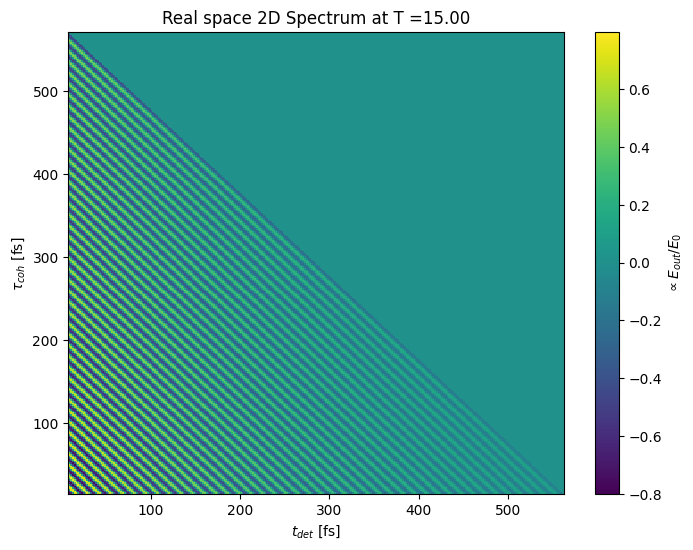

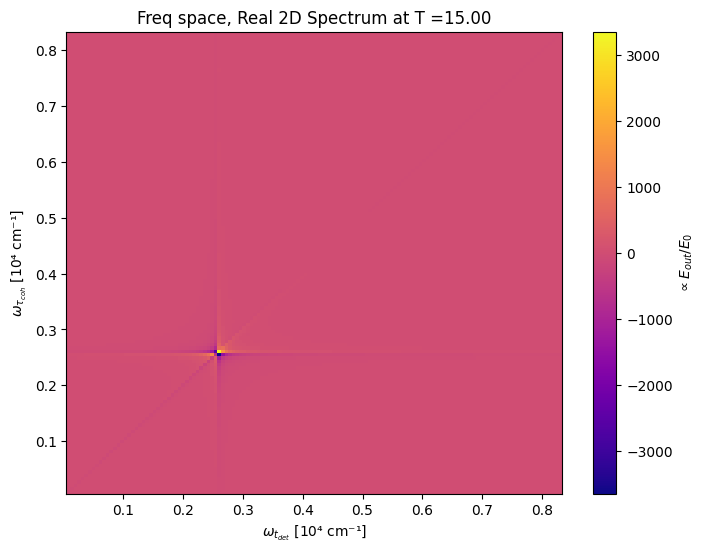

In [6]:
plot_positive_color_map(data_test_0[1], data_test_0[0], data_test_0[2], T=T_test, safe=False)
tfreqs = np.fft.fftfreq(len(data_test_0[1]), d=(data_test_0[1][1] - data_test_0[1][0]))
taufreqs = np.fft.fftfreq(len(data_test_0[0]), d=(data_test_0[0][1] - data_test_0[0][0]))
plot_positive_color_map(tfreqs, taufreqs, np.fft.fft2(data_test_0[2]), positive=True, type="real", space="freq", T=T_test, safe=False)

In [ ]:
# RESULTS from 2D Spectroscopy with all phases and times_T, already averaged over all phi
RESULT = main(phases, times_T)

In [ ]:
# Example usage
global_time_result, global_freq_result = extend_and_transform_averaged_results(RESULT)

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/brmesolve.py:169: FutureWarning: c_ops, e_ops, args and options will be keyword only from qutip 5.3
  warnings.warn(


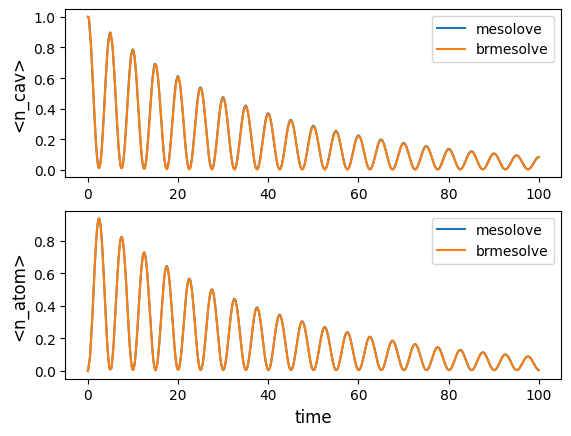

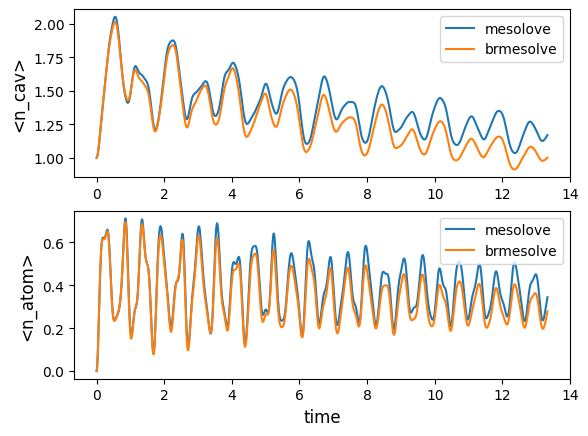

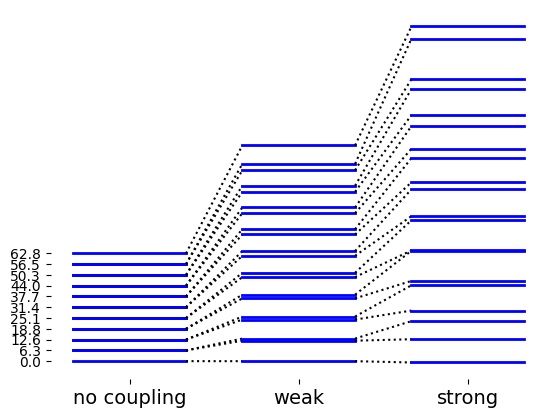

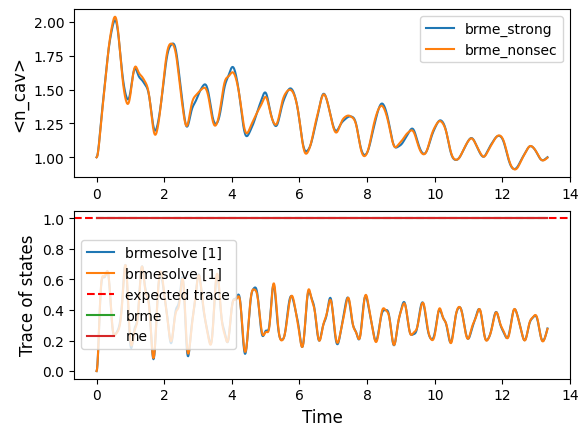

In [4]:
N = 10  # num. cavity modes

# operators
a = tensor(destroy(N), identity(2))
sm = tensor(identity(N), destroy(2))

# expectation operators
e_ops = [a.dag() * a, sm.dag() * sm]

# initial state
psi0 = ket2dm(tensor(basis(N, 1), basis(2, 0)))

w0 = 1.0 * 2 * np.pi
g_weak = 0.1 * 2 * np.pi
g_strong = 0.75 * 2 * np.pi
kappa = 0.05

# collapse operators (for mesolve)
c_ops = [np.sqrt(kappa) * a]
# noise power spectrum (for brmesolve)
a_ops = [[(a + a.dag()), lambda w: kappa * (w > 0)]]

# Hamiltonians
H_no = w0 * a.dag() * a + w0 * sm.dag() * sm
H_weak = w0 * a.dag() * a + w0 * sm.dag() * sm + \
         g_weak * (a + a.dag()) * (sm + sm.dag())
H_strong = w0 * a.dag() * a + w0 * sm.dag() * sm + \
           g_strong * (a + a.dag()) * (sm + sm.dag())


# times for simulation
times = np.linspace(0, 10 * 2 * np.pi / g_weak, 1000)
# simulation
result_me_weak = mesolve(H_weak, psi0, times, c_ops, e_ops)
result_brme_weak = brmesolve(H_weak, psi0, times, a_ops, e_ops)
fig, axes = plot_expectation_values(
    [result_me_weak, result_brme_weak], ylabels=["<n_cav>", "<n_atom>"]
)
for ax in axes:
    ax.legend(['mesolove', 'brmesolve'], loc='upper right')
    
    
# times for simulation
times = np.linspace(0, 10 * 2 * np.pi / g_strong, 1000)
# simulation
result_me_strong = mesolve(H_strong, psi0, times, c_ops, e_ops)
result_brme_strong = brmesolve(H_strong, psi0, times, a_ops, e_ops)
fig, axes = plot_expectation_values(
    [result_me_strong, result_brme_strong], ylabels=["<n_cav>", "<n_atom>"]
)
for ax in axes:
    ax.legend(['mesolove', 'brmesolve'], loc='upper right')

plot_energy_levels([H_no, H_weak, H_strong],
                   h_labels=["no coupling", "weak", "strong"]);





result_brme_nonsec = brmesolve(H_strong, psi0, times, a_ops,
                               sec_cutoff=-1, e_ops=e_ops)
fig, axes = plot_expectation_values(
    [result_brme_strong, result_brme_nonsec], ylabels=["<n_cav>", "<n_atom>"]
)
for ax in axes:
    ax.legend(['brme_strong', 'brme_nonsec'], loc='upper right')



# calculate states for weak coupling
me_states = mesolve(H_weak, psi0, times, c_ops, e_ops=[])
brme_states = brmesolve(H_weak, psi0, times, a_ops, e_ops=[])
# plot the traces and expected trace
plt.axhline(1.0, label="expected trace", c="red", linestyle="--")
plt.plot(times, [state.tr() for state in brme_states.states], label="brme")
plt.plot(times, [state.tr() for state in me_states.states], label="me")
plt.legend(), plt.xlabel("Time"), plt.ylabel("Trace of states");